# Lime Algorithm
Source: https://towardsdatascience.com/interpretable-machine-learning-for-image-classification-with-lime-ea947e82ca13

In [33]:
import numpy as np
import skimage
from sklearn.linear_model import LinearRegression
import sklearn.metrics
import copy
import skimage.segmentation
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.inception_v3 import InceptionV3

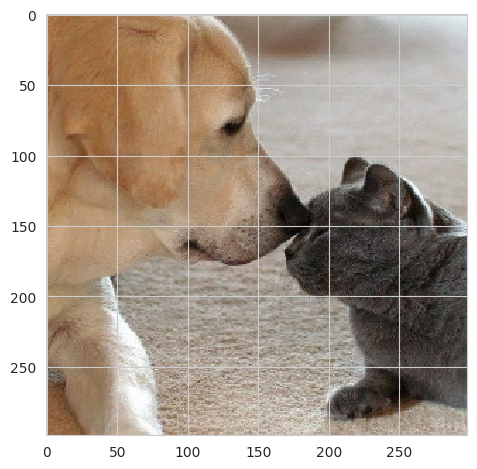

In [34]:
Xi = skimage.io.imread("https://arteagac.github.io/blog/lime_image/img/cat-and-dog.jpg")
Xi = skimage.transform.resize(Xi, (299, 299))
Xi = (Xi - 0.5) * 2  #Inception pre-processing
skimage.io.imshow(Xi / 2 + 0.5)  # Show image before inception preprocessing

In [35]:
np.random.seed(222)
inceptionV3_model = InceptionV3()  #Load pretrained model
preds = inceptionV3_model.predict(Xi[np.newaxis, :, :, :])
top_pred_classes = preds[0].argsort()[-5:][::-1]  # Save ids of top 5 classes
decode_predictions(preds)[0]  #Print top 5 c

1/1 [==============================] - 1s 674ms/step


[('n02099712', 'Labrador_retriever', 0.8182903),
 ('n02099601', 'golden_retriever', 0.01592988),
 ('n02093428', 'American_Staffordshire_terrier', 0.010066491),
 ('n02108422', 'bull_mastiff', 0.009287072),
 ('n02109047', 'Great_Dane', 0.008600978)]

In [36]:
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4, max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

71

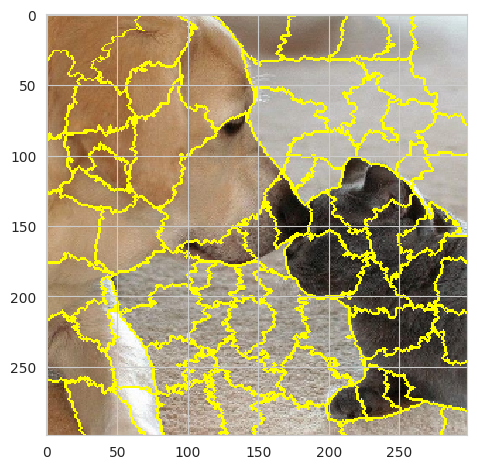

In [37]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi / 2 + 0.5, superpixels))

In [38]:
#Generate perturbations
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))

In [39]:
def perturb_image(img, perturbation, segments):
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
        mask[segments == active] = 1
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image * mask[:, :, np.newaxis]
    return perturbed_image

[1 1 1 1 0 0 1 0 1 0 1 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 1 1 1 1 1 1 0 0 1 1
 1 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 0 0 0 1 0 0 1 0 1 0 1 1 1 0 1]


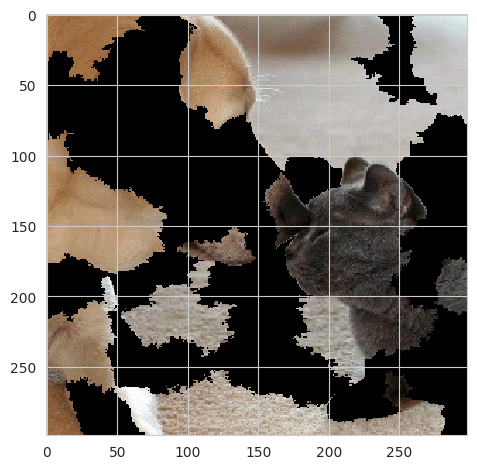

In [40]:
print(perturbations[0])
skimage.io.imshow(perturb_image(Xi / 2 + 0.5, perturbations[0], superpixels))

In [41]:
predictions = []
for pert in perturbations:
    perturbed_img = perturb_image(Xi, pert, superpixels)
    pred = inceptionV3_model.predict(perturbed_img[np.newaxis, :, :, :])
    predictions.append(pred)

predictions = np.array(predictions)
print(predictions.shape)

1/1 [==============================] - 0s 75ms/step
(150, 1, 1000)


In [42]:
original_image = np.ones(num_superpixels)[np.newaxis, :]  #Perturbation with all superpixels enabled
distances = sklearn.metrics.pairwise_distances(perturbations, original_image, metric='cosine').ravel()

#Transform distances to a value between 0 an 1 (weights) using a kernel function
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances ** 2) / kernel_width ** 2))  #Kernel function

In [43]:
perturbations[0]

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 1])

In [44]:
class_to_explain = top_pred_classes[0]  #Labrador class
predictions[0, 0, class_to_explain]

0.008538106

In [45]:
weights[0]

0.5151824807590573

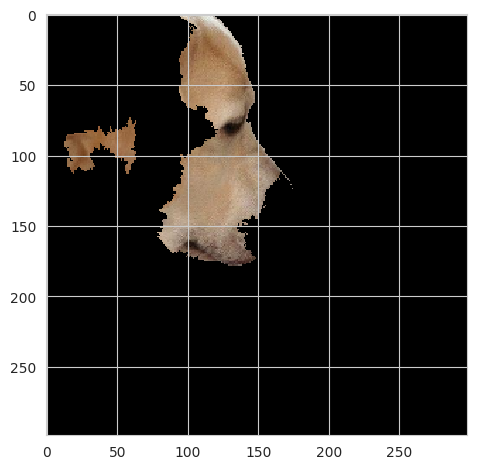

In [46]:
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:, :, class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]

#Use coefficients from linear model to extract top features
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:]

#Show only the superpixels corresponding to the top features
mask = np.zeros(num_superpixels)
mask[top_features] = True  #Activate top superpixels
skimage.io.imshow(perturb_image(Xi / 2 + 0.5, mask, superpixels))